This is the develop branch of the project.

This branch is where I will execute research and test new code. The first thing I'm testing is running everything through python and not using the C++ library. I will also be creating a local environment to run the program, which will require specific installation of packages.


 My model correlation
0.5260380655220431
0.4505132727946185

 SPI correlation
0.5194970903626085
0.498573500172721

 League Average Goals Scored
1.564592105263158
1.283565789473684
 


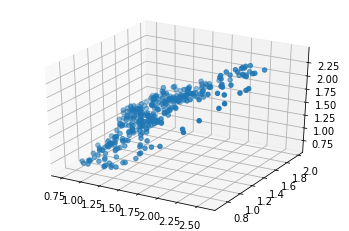

In [19]:
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import NearestNeighbors

# Code block will analyze EPL data
# Load the data into variables
spi_global_ranking = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_global_rankings.csv')
spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')
spi_matches_latest = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches_latest.csv')

EPL_match_odds_2122 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2021 2022.csv')
EPL_match_odds_2021 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2020 2021.csv')
EPL_match_odds_1920 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2019 2020.csv')
EPL_match_odds_1819 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2018 2019.csv')
EPL_match_odds_1718 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2017 2018.csv')
EPL_match_odds_1617 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2016 2017.csv')

# This section stores the data I want to use regarding betting markets in a new dataframe
keep_cols = ['HomeTeam', 'AwayTeam', 'B365H', 'B365A', 'B365D', 'FTR', 'HTR']
EPL_match_odds = EPL_match_odds_1617[keep_cols].sort_values(['HomeTeam', 'AwayTeam'])
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1718[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1819[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1920[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_2021[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_2122[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))

# This section converts the data into usable forms
# Converting between decimal odds and implied probability is just y = 1/x
EPL_match_odds['B365A'] = EPL_match_odds['B365A'].apply(lambda x: 1/x)
EPL_match_odds['B365D'] = EPL_match_odds['B365D'].apply(lambda x: 1/x)
EPL_match_odds['B365H'] = EPL_match_odds['B365H'].apply(lambda x: 1/x)

spi_matches_EPL = spi_matches[spi_matches['league'] == 'Barclays Premier League']
spi_matches_EPL = spi_matches_EPL.replace(to_replace='AFC Bournemouth', value='Bournemouth').sort_values(['season', 'team1', 'team2'])

# Arrays to build the game_data DataFrame
season = [np.array(spi_matches_EPL['season'])[x+10] for x in range(len(spi_matches_EPL) -10)]
date = [np.array(spi_matches_EPL['date'])[x+10] for x in range(len(spi_matches_EPL) - 10)]
hometeam = [np.array(spi_matches_EPL['team1'])[x+10] for x in range(len(spi_matches_EPL) - 10)]
home_goals = [np.array(spi_matches_EPL['xg1'])[x+10] for x in range(len(spi_matches_EPL) - 10)]
away_goals = [np.array(spi_matches_EPL['xg2'])[x+10] for x in range(len(spi_matches_EPL) - 10)]
awayteam = [np.array(spi_matches_EPL['team2'])[x+10] for x in range(len(spi_matches_EPL) - 10)]

# Object to handle data manipulation; initialized to create ratings
# Assumes spi_matches_EPL is the df being passed
class CalcTeamRatings:
  def __init__(self, home, away, date, df):
    self.home = home
    self.date = date
    self.away = away
    self.df = df[df['date'] < self.date].sort_values(['date'])
    self.df = self.df.dropna()
    self.home_df = self.df[self.df['team1'] == self.home]
    self.home_df = self.home_df.tail(30)
    self.away_df = self.df[self.df['team2'] == self.away]
    self.away_df = self.away_df.tail(30)
  def rollingAvgXG(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg1'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg1'].tail(10).mean() + self.home_df['xg1'].mean()) / 2)
    old_games = self.home_df['xg1'].head(20).mean()
    new_games = self.home_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def rollingAvgXGA(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg2'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg2'].tail(10).mean() + self.home_df['xg2'].mean()) / 2)
    old_games = self.home_df['xg2'].head(20).mean()
    new_games = self.home_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXG(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg2'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg2'].tail(10).mean() + self.away_df['xg2'].mean()) / 2)
    old_games = self.away_df['xg2'].head(20).mean()
    new_games = self.away_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXGA(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg1'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg1'].tail(10).mean() + self.away_df['xg1'].mean()) / 2)
    old_games = self.away_df['xg1'].head(20).mean()
    new_games = self.away_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)

lg_avg_home = spi_matches_EPL['xg1'].sum()/len(spi_matches_EPL)
lg_avg_away = spi_matches_EPL['xg2'].sum()/len(spi_matches_EPL)

game_data = pd.DataFrame({'Season': np.array(season),
                          'Date': np.array(date),
                          'Home Team': np.array(hometeam),
                          'Away Team': np.array(awayteam),
                          'Home Goals': np.array(home_goals),
                          'Away Goals': np.array(away_goals)})

# This slice creates a sample that can be used to generate better atk/def ratings
# Keep in mind that this extra data used to create ratings does not apply to promoted teams
game_data = game_data[game_data['Season'] > 2016].reset_index(drop=True)

game_data['Object'] = [CalcTeamRatings(game_data['Home Team'][x], game_data['Away Team'][x], game_data['Date'][x], spi_matches_EPL) for x in range(len(game_data))]
game_data['Home Atk'] = [game_data['Object'][x].rollingAvgXG() for x in range(len(game_data))]
game_data['Home Def'] = [game_data['Object'][x].rollingAvgXGA() for x in range(len(game_data))]
game_data['Away Atk'] = [game_data['Object'][x].away_rollingAvgXG() for x in range(len(game_data))]
game_data['Away Def'] = [game_data['Object'][x].away_rollingAvgXGA() for x in range(len(game_data))]

game_data['Home Atk'] = game_data['Home Atk'].replace(to_replace=0, value=np.nan)
game_data['Home Def'] = game_data['Home Def'].replace(to_replace=0, value=np.nan)
game_data['Away Atk'] = game_data['Away Atk'].replace(to_replace=0, value=np.nan)
game_data['Away Def'] = game_data['Away Def'].replace(to_replace=0, value=np.nan)
game_data = game_data.dropna()
game_data = game_data.reset_index(drop=True)

sample_data = game_data[game_data['Season'] < 2021]
test_data = game_data[game_data['Season'] == 2021].reset_index(drop=True)
sample_home = [[sample_data['Home Atk'][x], sample_data['Away Def'][x]] for x in range(len(sample_data))]
sample_away = [[sample_data['Away Atk'][x], sample_data['Home Def'][x]] for x in range(len(sample_data))]

n = 50
neigh_home = NearestNeighbors(n_neighbors=n)
neigh_home.fit(sample_home)
neigh_away = NearestNeighbors(n_neighbors=n)
neigh_away.fit(sample_away)

model_results_home = [neigh_home.kneighbors([[test_data['Home Atk'][x], test_data['Away Def'][x]]]) for x in range(len(test_data))]
model_results_away = [neigh_away.kneighbors([[test_data['Away Atk'][x], test_data['Home Def'][x]]]) for x in range(len(test_data))]

# A note about the the format of the returned data in model_results
# it is returned as a 4 dimensional array
# the first dimension is index of the element from test_data
# the second is 0 for an array containing the distances of the test data to sample neighbors
# or 1 for an array of indices of neighbors in the sample data
# the third is empty and therefore always 0; this results from the nested structure of the input data
# the fourth is an individual distance or index of a neighbor of the sample data

weights = [model_results_home[x][0][0] for x in range(len(model_results_home))]
indices = [model_results_home[x][1][0] for x in range(len(model_results_home))]
model_xg_home = []
for x in indices:
  y = [sample_data['Home Goals'][x[z]] for z in range(n)]
  y = np.array(y).sum()/n
  model_xg_home.append(y)

weights = [model_results_away[x][0][0] for x in range(len(model_results_away))]
indices = [model_results_away[x][1][0] for x in range(len(model_results_away))]
model_xg_away = []
for x in indices:
  y = [sample_data['Away Goals'][x[z]] for z in range(n)]
  y = np.array(y).sum()/(n)
  model_xg_away.append(y)

test_data['Model xG Home'] = np.array(model_xg_home)
test_data['Model xG Away'] = np.array(model_xg_away)
test_data = test_data.dropna()

fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = np.array(test_data['Away Atk'])
ydata = np.array(test_data['Home Def'])
zdata = np.array(test_data['Model xG Away'])
ax.scatter3D(xdata, ydata, zdata)

print("\n", "My model correlation")
print(test_data['Model xG Home'].corr(test_data['Home Goals']))
print(test_data['Model xG Away'].corr(test_data['Away Goals']))

print("\n", "SPI correlation")
print(spi_matches_EPL['proj_score1'].corr(spi_matches_EPL['xg1']))
print(spi_matches_EPL['proj_score2'].corr(spi_matches_EPL['xg2']))

print("\n", "League Average Goals Scored")
print(lg_avg_home)
print(lg_avg_away)
print(" ")

At this point, my C++ code works in the python script. I'll use it to add a column to a dataframe that has many rows to verify speed.

k-Nearest Neighbors model with weighted team ratings returns an out of sample correlation of .526 for home goals (vs .519 for SPI).

Next steps: pull over dataframe building from SPI Research notebook and rebuild KNN model into a version to predicts classifications. Each datapoint in the sample will have 7 components: home atk/def, away atk/def, home odds to win, away odds to win, odds of a draw. The classifier will be the most profitable bet (all winning bets of a certain type multiplied by winnings divided by total cost of the neighbor group). All odds have to be converted from betting lines to implied probabilities for the model to make sense